# 📌 Prédiction des Cultures Agricoles

Ce notebook vise à **prédire le type de culture** adapté à un terrain donné en fonction de ses caractéristiques chimiques et climatiques (N, P, K, température, humidité, pH, précipitations). Nous utilisons un modèle de **Machine Learning** pour automatiser cette recommandation.


## 1️⃣ Chargement des données


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_csv("../input/data.csv", sep=";", skipinitialspace=True)
display(df.head())

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,"20,87974371","82,00274423","6,502985292","202,9355362",rice
1,85,58,41,"21,77046169","80,31964408","7,038096361","226,6555374",rice
2,60,55,44,"23,00445915","82,3207629","7,840207144","263,9642476",rice
3,74,35,40,"26,49109635","80,15836264","6,980400905","242,8640342",rice
4,78,42,42,"20,13017482","81,60487287","7,628472891","262,7173405",rice


## 2️⃣ Nettoyage des données


In [2]:
df.replace(',', '.', regex=True, inplace=True)
cols_to_convert = ['temperature', 'humidity', 'ph', 'rainfall']
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.to_csv("data_cleaned.csv", index=False, sep=";")
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


None

## 3️⃣ Détection et suppression des valeurs aberrantes


In [3]:
for col in ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]
df.to_csv("data_outliers_removed.csv", index=False, sep=";")
display(df.describe())

,N,P,K,temperature,humidity,ph,rainfall
count,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000
mean,54.210184,45.161430,32.745937,25.711188,69.770583,6.493357,101.474427
std,37.928591,22.506246,16.614550,4.155121,22.649324,0.680293,52.432682
min,0.000000,5.000000,5.000000,15.330426,14.258040,4.603563,20.211267
25%,22.000000,25.000000,20.000000,23.267408,57.749008,6.033501,61.144916
50%,40.000000,46.000000,28.000000,25.839646,77.331406,6.470301,94.279811
75%,89.000000,63.000000,45.000000,28.518889,88.288685,6.944110,130.387488
max,140.000000,95.000000,85.000000,36.750875,99.981876,8.399136,248.859299


## 4️⃣ Analyse exploratoire : Distribution des variables


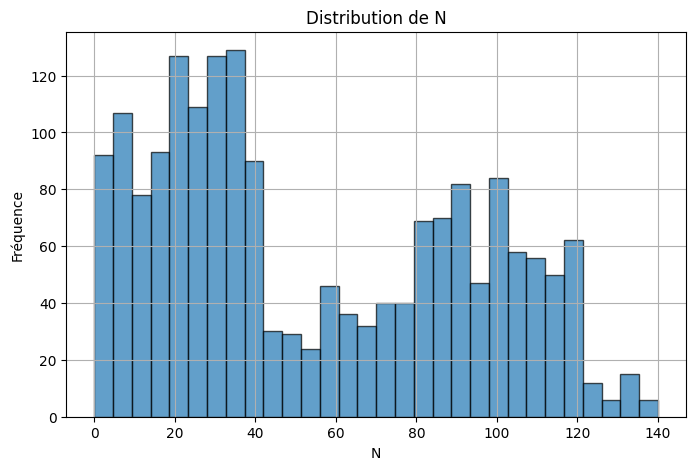

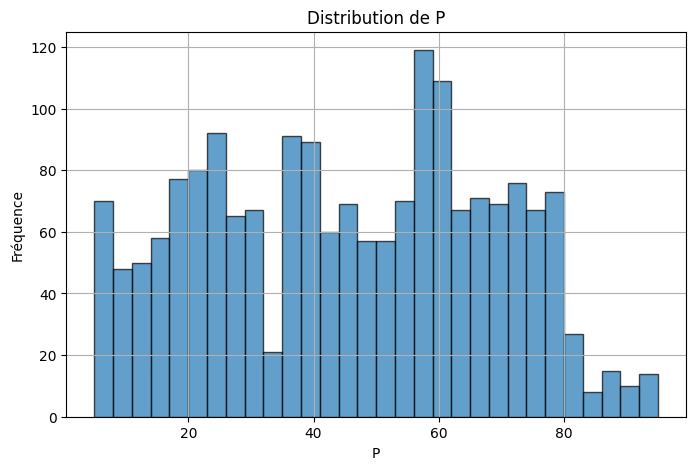

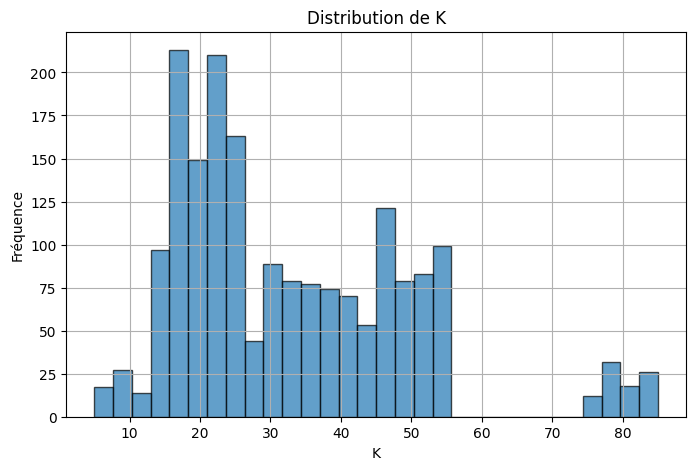

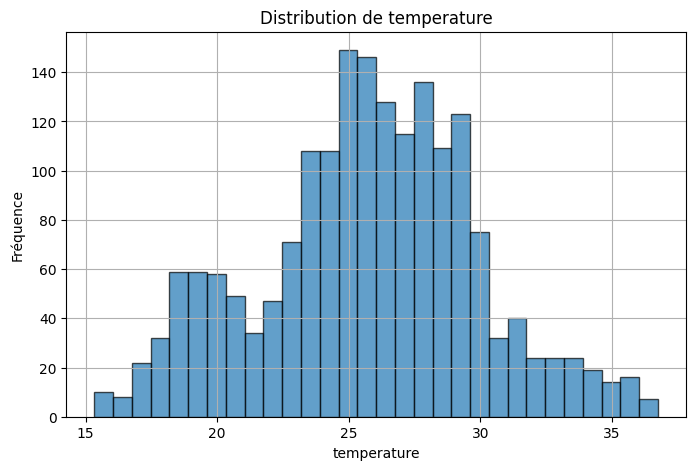

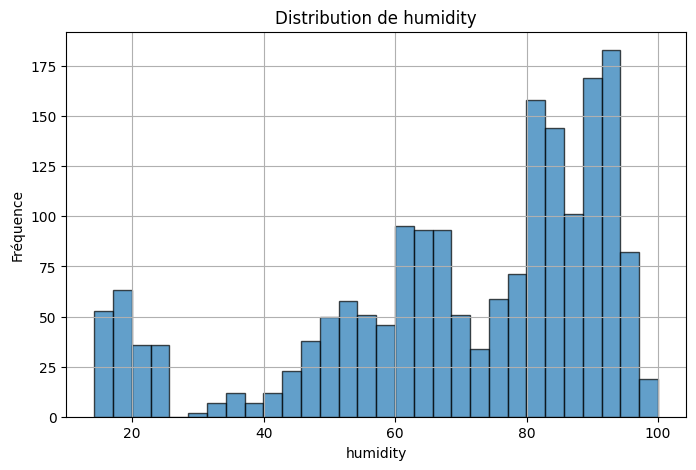

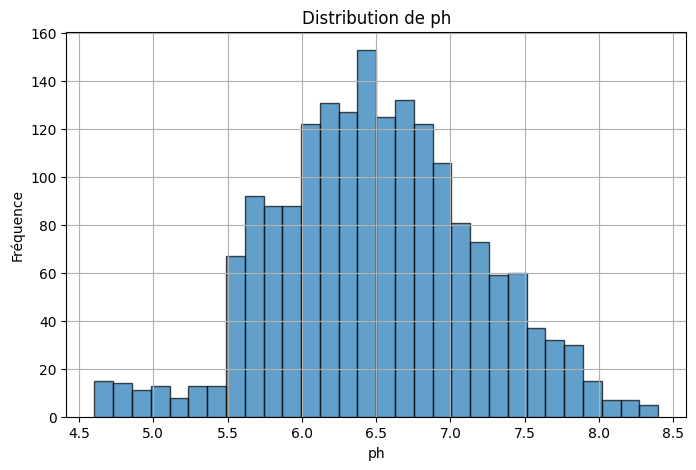

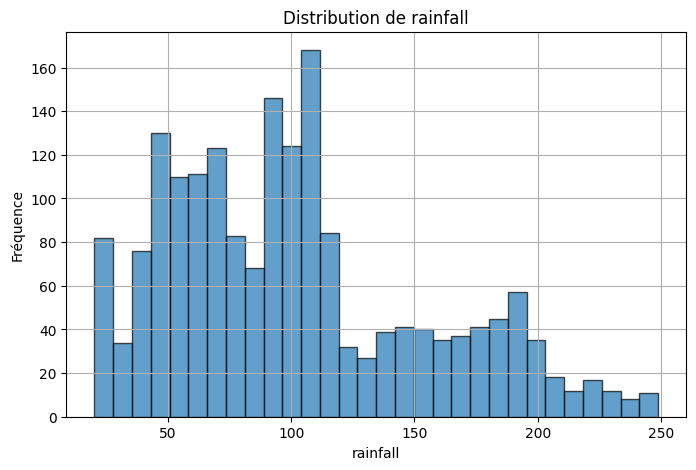

In [4]:
for col in ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']:
    plt.figure(figsize=(8, 5))
    plt.hist(df[col], bins=30, edgecolor='black', alpha=0.7)
    plt.xlabel(col)
    plt.ylabel('Fréquence')
    plt.title(f'Distribution de {col}')
    plt.grid(True)
    plt.show()

## 5️⃣ Répartition des cultures


C:\Users\Elinor\AppData\Local\Temp\ipykernel_10004\791119517.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


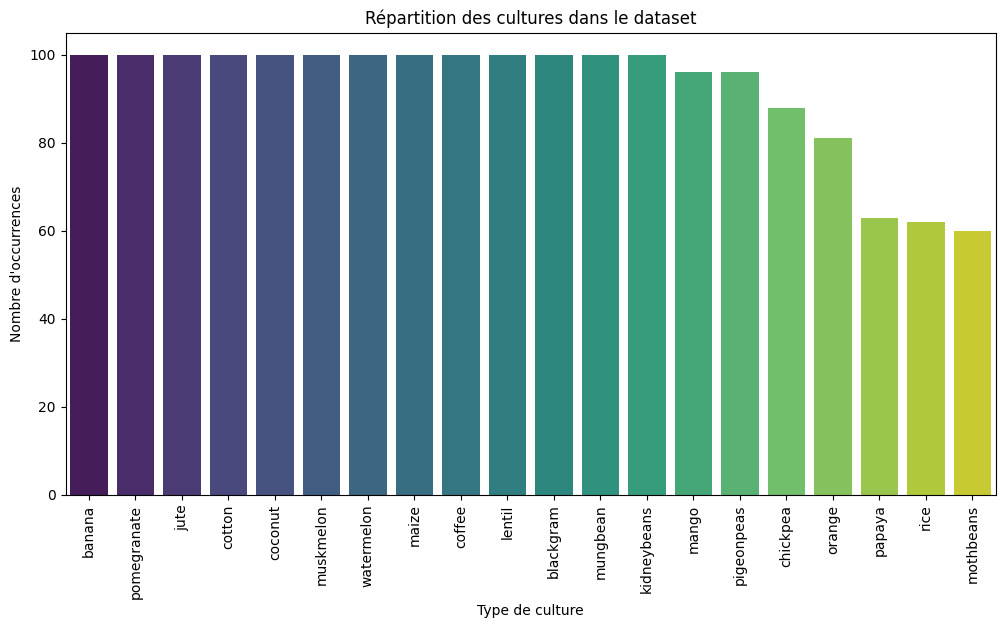

In [5]:
if 'label' in df.columns:
    label_counts = df['label'].value_counts()
    plt.figure(figsize=(12, 6))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
    plt.xlabel("Type de culture")
    plt.ylabel("Nombre d'occurrences")
    plt.title("Répartition des cultures dans le dataset")
    plt.xticks(rotation=90)
    plt.show()

## 6️⃣ Préparation des données pour le Machine Learning


In [6]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
X = df.drop(columns=['label'])
y = df['label']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
np.save("X_train.npy", X_train)
np.save("X_test.npy", X_test)
np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)

## 7️⃣ Entraînement du modèle Random Forest


In [7]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## 8️⃣ Évaluation du modèle


In [8]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle : {accuracy:.2f}")
print("Rapport de classification :")
print(classification_report(y_test, y_pred))
joblib.dump(model, "trained_model.pkl")

Précision du modèle : 0.99
Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        20
           6       0.77      1.00      0.87        10
           7       1.00      1.00      1.00        23
           8       1.00      1.00      1.00        18
           9       1.00      1.00      1.00        17
          10       1.00      1.00      1.00        13
          11       1.00      1.00      1.00        11
          12       1.00      1.00      1.00        24
          13       1.00      1.00      1.00        25
          14       1.00      1.00      1.00        22
          15       1.00      1.00      1.00        14
          16       1.00   

['trained_model.pkl']

## 9️⃣ Test du modèle


In [9]:
loaded_model = joblib.load("trained_model.pkl")
test_pred = loaded_model.predict(X_test[:5])
print("Prédictions sur les 5 premières valeurs de test :", test_pred)

Prédictions sur les 5 premières valeurs de test : [ 5 19  8  3 14]
